In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [6]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [7]:
connectivity_data

In [8]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask

# def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures, model_ordering_leaf, model_region_surface, source_ordering, target_ordering, eval_cres):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(eval_cres)

#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions                               
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)    
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = model_ordering_leaf[i,0]#structure_major_dictionary[source_ordering[i]]
#             gamma = surfaces[sid].gamma#gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction3(cache,
#                                                       connectivity_data.structure_datas[sid],
#                                                       exp_structures = structures[sid],
#                                                       model_region_leaf = model_ordering_leaf[i,1],
#                                                        model_region_surface = model_region_surface[i,1],
#                                                       prediction_region= source_ordering[i],
#                                                       cre = eval_cres[c],
#                                                       gamma = surfaces[sid].bestgamma,
#                                                       surface = surfaces[sid],
#                                                       cre_model = True)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)

# def get_region_prediction3(cache, structure_data,  exp_structures, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    
#     #model_experiments = np.where(exp_structures == model_region)[0]
#     model_experiments_leaf = np.where(exp_structures == model_region_leaf)[0]
#     nexp = len(model_experiments_leaf)
    
#     cres = structure_data.crelines[model_experiments_leaf]
#     mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

# #     if surface != None and cre_model != True:
# #         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
# #         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
# #         predictions = get_nw_predictions(projections, losses, gamma)
# #         output = np.mean(predictions, axis = 0)
        
#     if surface != None and cre_model == True:
#         projections = structure_data.reg_proj_norm[model_experiments_leaf]
#         centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
#         means = get_means(projections, cres, np.repeat(model_region_surface,nexp))
#         #print(means)
#         print(prediction_region)
#         #print(prediction_region, model_region,means.keys())
#         #supposed to check if theres a cre in that region
#         if np.isin(model_region_surface, list(means.keys())):
#             if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
#                 losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region_surface])
#                 predictions = get_nw_predictions(projections, losses, gamma)
#                 output = np.mean(predictions, axis = 0)
#             else:
#                 output = np.zeros(projections.shape[1])
#                 output[:] = np.nan
#         else:
#             output = np.zeros(projections.shape[1])
#             output[:] = np.nan           
# #     if surface == None and cre_model != True:
# #         means = get_means(projections, cres, [model_region])
# #         predictions = means[cres]
# #         output = np.mean(predictions, axis = 0)
        
#     if surface == None and cre_model == True:
        
        
#         modelcre_experiments = np.where(cres == cre)[0]
#         if len(modelcre_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
#             centroids = structure_data.centroids[model_experiments][modelcre_experiments]
#             #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
            
#     if surface == None and cre_model == False:
        
#         if len(model_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments]
#             centroids = structure_data.centroids[model_experiments]
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
        
#     return(output)


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      #structures_sid = structures[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
       
    return(output)


In [9]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [11]:
#str_cre (zack)
# frac_learn = np.ones(12)
# frac_learn[4] = .1
# sls = {}
# gammas_surface = 100000 * np.ones(12)
# gammas_surface[0] = 10
# gammas_surface[1] = 10
# gammas_surface[2] = 1000
# gammas_surface[3] = 100
# gammas_surface[4] = 20000
# gammas_surface[3] = 100
# gammas_surface[5] = 100
# gammas_surface[6] = 10
# gammas_surface[7] = 100
# gammas_surface[8] = 100
# gammas_surface[9] = 25
# gammas_surface[10] = 1000
# gammas_surface[11] = 1000

frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000


In [12]:
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = gammas_surface[m])
    
    



0
1
2
3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


5
6
7
8
9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [13]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
class Crossval:
    
    def __init__(self):
        2+2

In [15]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [17]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions
twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:107: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


[autoreload of seaborn.external.six failed: Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/seaborn/external/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'Non

{512: array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         

In [18]:
twostage_leaf_creleaf2.meanloss

array([0.03862558, 0.4966726 , 0.08387246, 0.21983532, 0.12718922,
       0.11226157, 0.16358549, 0.05566028, 0.22811406, 0.13767042,
       0.04806401, 0.32689735])

In [158]:
crelist = ['C57BL/6J']
eval_cres = ['C57BL/6J']
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(list1)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)

# model_ordering_leaf = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
# model_ordering_summary = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_summaries = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()


In [20]:
surfaces = {}
#surfaces_leaf = {}
for m in range(12):
    sid = major_structure_ids[m]
    surfaces[sid] = connectivity_data.structure_datas[sid].loss_surface_cv
    surfaces[sid].bestgamma =  gammas[twostage_leaf_creleaf2.bestgamma[m]]#gs[m]#gammas[twostage_str_creleaf2.bestgamma[m]]
    
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [1]:
ontological_order_leaves_majors_names

NameError: name 'ontological_order_leaves_majors_names' is not defined

In [160]:
ontological_order_leaves_majors_names = np.asarray([ia_map[ontological_order_leaves_majors[i]] for i in range(len(ontological_order_leaves_majors))])
ontological_order_summary_majors = get_aligned_ids(ontological_order,major_structure_ids)
ontological_order_summary_majors_names = np.asarray([ia_map[ontological_order_summary_majors[i]] for i in range(len(ontological_order_summary_majors))])

In [137]:
np.save('/Users/samsonkoelle/ontological_order_summary_majors_names', ontological_order_summary_majors_names)
np.save('/Users/samsonkoelle/ontological_order_leaves_majors_names', ontological_order_leaves_majors_names)

In [147]:
st.ancestor_ids([ontological_order[-2]])

[[91, 519, 512, 8, 997]]

In [148]:
ia_map[91]

'IP'

In [149]:
major_structure_ids

[512, 703, 1089, 1097, 315, 313, 354, 698, 771, 803, 477, 549]

In [144]:
major_structures

['CB',
 'CTXsp',
 'HPF',
 'HY',
 'Isocortex',
 'MB',
 'MY',
 'OLF',
 'P',
 'PAL',
 'STR',
 'TH']

In [44]:
#connectivity_data
surfaces = surfaces#_str
cres = crelist
structures_smooth = leafs
structures_surface = leafs
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_surfaces = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_leafs = model_ordering_leafs#[117:123]
model_ordering_surfaces = model_ordering_summaries#[117:123]
eval_cres = eval_cres
source_ordering = ontological_order_leaves#[117:123]
target_ordering= ontological_order
connectivity_matrices = get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_leafs, source_ordering, target_ordering, eval_cres)
        

0 68.0
1 667.0
2 526157192.0
3 526157196.0
4 526322264.0
5 320.0
6 943.0
7 648.0
8 844.0
9 882.0
10 656.0
11 962.0
12 767.0
13 1021.0
14 1085.0
15 558.0
16 838.0
17 654.0
18 702.0
19 889.0
20 929.0
21 981.0
22 201.0
23 1047.0
24 1070.0
25 1038.0
26 1062.0
27 1030.0
28 113.0
29 1094.0
30 1128.0
31 478.0
32 510.0
33 878.0
34 657.0
35 950.0
36 974.0
37 1102.0
38 2.0
39 450.0
40 854.0
41 577.0
42 625.0
43 945.0
44 1026.0
45 1006.0
46 670.0
47 1086.0
48 1111.0
49 9.0
50 461.0
51 182305693.0
52 182305697.0
53 182305701.0
54 182305705.0
55 182305709.0
56 182305713.0
57 873.0
58 806.0
59 1035.0
60 1090.0
61 862.0
62 893.0
63 36.0
64 180.0
65 148.0
66 187.0
67 638.0
68 662.0
69 897.0
70 1106.0
71 1010.0
72 1058.0
73 857.0
74 849.0
75 527.0
76 600.0
77 678.0
78 252.0
79 156.0
80 243.0
81 735.0
82 251.0
83 816.0
84 847.0
85 954.0
86 1005.0
87 696.0
88 643.0
89 759.0
90 791.0
91 249.0
92 456.0
93 959.0
94 755.0
95 990.0
96 1023.0
97 520.0
98 598.0
99 1074.0
100 905.0
101 1114.0
102 233.0
103 601.0

In [179]:
creleaf_size = np.zeros(12)
for m in range(12):
    creleaf_size[m] = connectivity_data.creleaf2_index_matrices[major_structure_ids[m]].sum()

In [187]:
output = np.asarray([])
for m in range(12):
    output = np.concatenate([output, np.repeat(major_structures[m], creleaf_size[m])])

In [189]:
output = pd.DataFrame(output)

In [193]:
output

,0
0,CB
1,CB
2,CB
3,CB
4,CTXsp
...,...
971,TH
972,TH
973,TH
974,TH


In [201]:
output.columns = np.asarray(['Major structure'])

In [202]:
#palette="ch:.25",
output['Major structure']=output['Major structure'].astype('category')
#output

In [206]:
output

,Major structure
0,CB
1,CB
2,CB
3,CB
4,CTXsp
...,...
971,TH
972,TH
973,TH
974,TH


In [215]:
 titanic = sns.load_dataset("titanic")

In [216]:
sns.catplot(x="class", hue="who", col="survived",data=titanic, kind="count",height=4, aspect=.7)

TypeError: Vertical orientation requires numeric `y` variable.

In [ ]:
if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [210]:
help(sns.countplot)

Help on function countplot in module seaborn.categorical:

countplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None, **kwargs)
    Show the counts of observations in each categorical bin using bars.
    
    A count plot can be thought of as a histogram across a categorical, instead
    of quantitative, variable. The basic API and options are identical to those
    for :func:`barplot`, so you can compare counts across nested variables.
    
    
    Input data can be passed in a variety of formats, including:
    
    - Vectors of data represented as lists, numpy arrays, or pandas Series
      objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
    - A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
      variables will determine how the data are plotted.
    - A "wide-form" DataFrame, such that each numeric column will be plotted.
    - An array or list 

In [211]:
sns.catplot(x='Major structure',  kind="count", data=output)

TypeError: Vertical orientation requires numeric `y` variable.

In [204]:
output

,Major structure
0,CB
1,CB
2,CB
3,CB
4,CTXsp
...,...
971,TH
972,TH
973,TH
974,TH


In [164]:
connectivity_matrices.shape

(1, 541, 577)

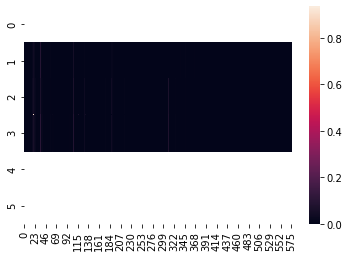

In [39]:
sns.heatmap(connectivity_matrices[0])

In [47]:
ontological_order_leaves.shape

(541,)

In [59]:
ipsi_target_regions.shape, contra_target_regions.shape , cnames.shape

((291,), (286,), (577,))

In [128]:
#target_ordering= ontological_order_leaves

rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])


ccomb = np.vstack([np.concatenate([np.repeat('ipsi',291),np.repeat('contra',286)]), cnames])
ccomb = np.asarray(ccomb)
tuples2 = list(zip(*ccomb))
cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])

In [129]:
cnam_multi[576]

('contra', 'DN')

In [130]:
rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])

In [131]:
#connectivity_matrices_sumall = pd.DataFrame(connectivity_matrices[0], columns = cnames, index=rnames)
connectivity_matrices_sumall = pd.DataFrame(connectivity_matrices[0], columns = cnam_multi, index=rnames)

In [132]:
connectivity_matrices_sumall.to_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv')

In [ ]:
con

In [ ]:
loocvpredictions

In [50]:
# #target_ordering= ontological_order_leaves

# rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
# ipsi_target_regions = connectivity_data.ipsi_target_regions
# contra_target_regions = connectivity_data.contra_target_regions                               
# ipsi_indices= np.asarray([])
# contra_indices = np.asarray([])
# for iy in target_ordering: 
#     ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#     contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
# ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
# contra_indices = np.asarray(contra_indices, dtype = int)    
# reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
# ntarget = len(reorder)

# colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
# cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])

# connectivity_matrices_sumall = pd.DataFrame(connectivity_matrices[0], columns = cnames, index=np.asarray(['VISp1','VISp2/3','VISp4','VISp5','VISp6a','VISp6b']))

In [51]:
# fig, ax = plt.subplots(figsize = (15,15))
# sns.heatmap(connectivity_matrices_sumall)

In [25]:
#connectivity_data = connectivity_data
#surfaces = surfaces
#cres
#structures_smooth = structures_smooth
#structures_surface
#model_ordering_leafs
#model_ordering_surfaces  = model_ordering_leafs
#source_ordering
#target_ordering
#eval_cres

In [52]:
#len(target_ordering)